In [15]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [2]:
# Reset pseudo random number generator so that the results are reproducible.
seed = 42
np.random.seed(seed)

### Generate target function and its noisy version.

In [3]:
# Sets the number of examples.
N = 30

# Attribute.
x = np.sort(2*np.random.rand(N, 1) - 1, axis=0)

# Target function.
y = 1 + 0.5*x + 2*(x**2)

# Noisy function.
y_noisy = y + 0.3*np.random.randn(N, 1)

Ntest = 100
x_test = np.linspace(-1, 1, Ntest).reshape(Ntest, 1)
y_test = 1 + 0.5*x_test + 2*(x_test**2) + 0.3*np.random.randn(Ntest, 1)

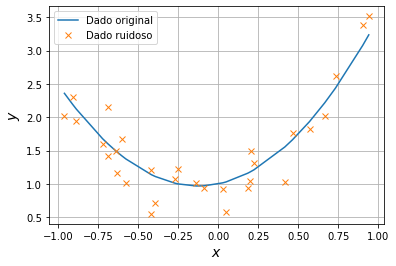

In [4]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()

### Define the polinomial order

In [5]:
# Polynomial order.
model_order = 15

### Define the regularization factor

In [6]:
# Regularization factor.
lambdas = [0, 0.0194, 1]

### Elastic-net with $\kappa$ = 0.5

Lambda: 0.0000e+00:
[1.53091512]
[[ 0.00000000e+00 -3.26619148e-01  6.26027965e+00  9.11715885e+00
  -8.93092859e+01 -9.13730327e+01  5.26147653e+02  5.43742416e+02
  -1.51291387e+03 -1.71566113e+03  2.27078228e+03  2.80890380e+03
  -1.70290215e+03 -2.25122856e+03  5.02976634e+02  6.97684255e+02]]
---------------------------------------------
Lambda: 1.9400e-02:
[1.53091512]
[ 0.          0.25343189  0.49248341  0.          0.13335356  0.
  0.          0.         -0.          0.         -0.          0.01721058
 -0.          0.03627145 -0.          0.04812886]
---------------------------------------------
Lambda: 1.0000e+00:
[1.53091512]
[0.         0.         0.0418062  0.         0.02146643 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
---------------------------------------------


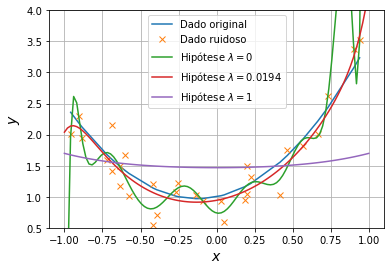

In [7]:
include_bias = True

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
for i in range(0,len(lambdas)):

    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = ElasticNet(alpha=lambdas[i], l1_ratio=0.5, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    # Print coefs
    print('Lambda: %1.4e:' % (lambdas[i]))
    print(model.named_steps['reg'].intercept_)
    print(model.named_steps['reg'].coef_)
    print('---------------------------------------------')
    # Predict.
    y_test_regul = model.predict(x_test)
    # Plot prediction.
    plt.plot(x_test, y_test_regul, label='Hipótese $\lambda=$'+str(lambdas[i]))
    
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
#Show the plot.
plt.show()

### Weight variation versus lambda

In [8]:
include_bias = True

M = 1000
lambdas = np.linspace(1e-5,1, M)

a_hist = np.zeros((model_order, M)) if include_bias == False else np.zeros((model_order+1, M))
norm_hist = np.zeros((1, M))
error_test = []

for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = ElasticNet(alpha=lambdas[i], l1_ratio=0.5, random_state=seed, tol=1) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    a = model.named_steps['reg'].coef_
    a_hist[:,i] = a
    norm_hist[:,i] = np.linalg.norm(a)
    # Predict.
    y_test_regul = model.predict(x_test)
    error_test.append((mean_squared_error(y_test, y_test_regul)))

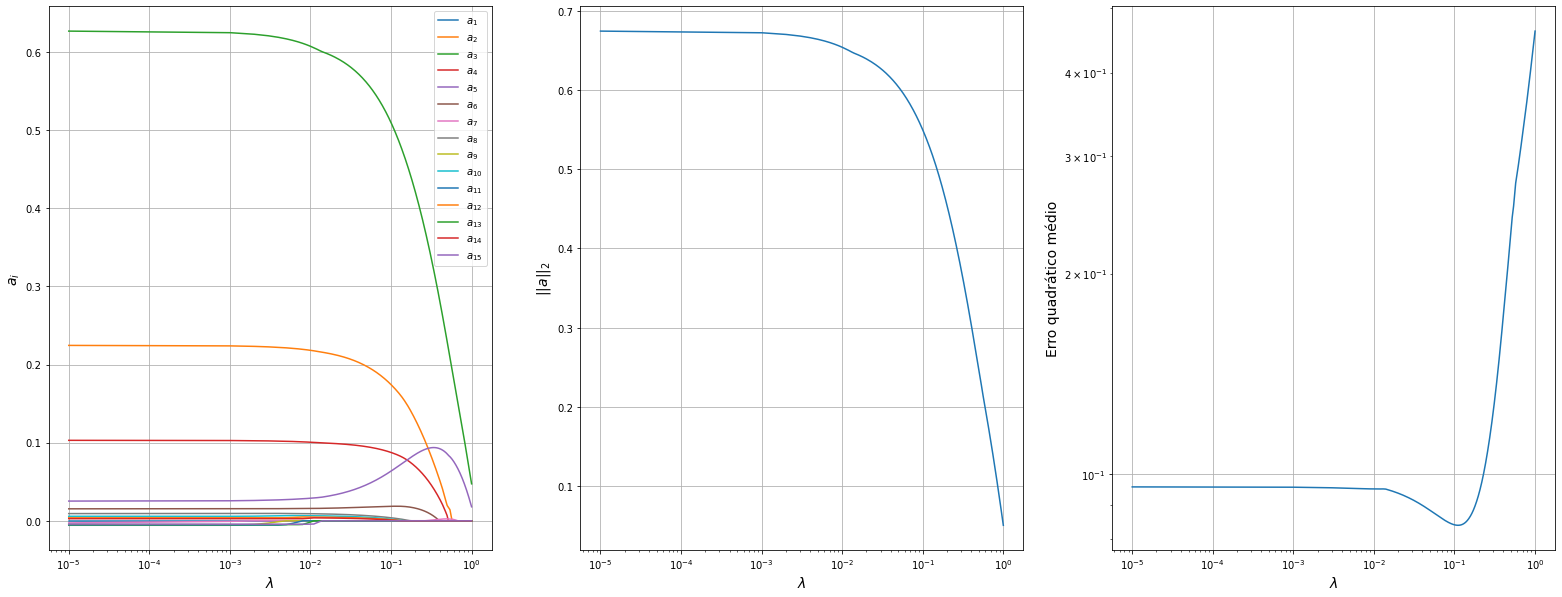

In [9]:
# Generate figure.
fig = plt.figure(figsize=(27,10))

# Plot weight.
ax = plt.subplot(1, 3, 1)
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper right')
plt.grid()

# Plot norm.
ax = plt.subplot(1, 3, 2)
plt.plot(lambdas, norm_hist[0,:])
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$||a||_2$', fontsize=14)
plt.grid()

# Plot error.
ax = plt.subplot(1, 3, 3)
plt.plot(lambdas, error_test)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('Erro quadrático médio', fontsize=14)
plt.grid()

#Show the plot.
plt.show()

### ElasticNet CV for finding the best $\lambda$

In [10]:
M = 1000
alphas = np.logspace(-5,2,M)

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Ridge regressor.
reg = ElasticNetCV(alphas=alphas, tol=1, random_state=seed)
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

# Find the best alpha value.
clf.fit(x, y_noisy.ravel())

print('score:',clf.score(x, y_noisy.ravel()))

score: 0.876482860489242


In [11]:
clf['reg'].alpha_

0.014694918006248172

In [12]:
alphas = np.linspace(clf['reg'].alpha_/10,clf['reg'].alpha_*10,M)

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Ridge regressor.
reg = ElasticNetCV(alphas=alphas, random_state=seed)
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

# Find the best alpha value.
clf.fit(x, y_noisy.ravel())

print('score:',clf.score(x, y_noisy.ravel()))

score: 0.8787078641951339


In [13]:
clf['reg'].alpha_

0.019381405370402997

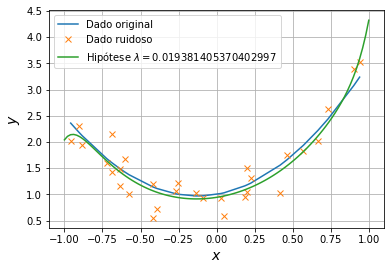

In [14]:
# Perform prediction.
y_test_pred = clf.predict(x_test)

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(x_test, y_test_pred, label='Hipótese $\lambda=$'+str(clf['reg'].alpha_))
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()